# Machine Learning Nanodegree Capstone
# Chat Room Recommendation

In [1]:
import os
import collections
import random
import numpy as np
from gensim.models import Doc2Vec

Using TensorFlow backend.


### Load Data

In [2]:
# path will need to be changed pending on where the repo is cloned to
os.chdir(os.path.expanduser('~/PycharmProjects/chat-room-recommendation/'))
lines = open('cornell-movie-dialogs-corpus/movie_lines.txt','r').read().split('\n')
conv_lines = open('cornell-movie-dialogs-corpus/movie_conversations.txt','r').read().split('\n')
character_metadata = open('cornell-movie-dialogs-corpus/movie_characters_metadata.txt','r').read().split('\n')
movie_metadata = open('cornell-movie-dialogs-corpus/movie_titles_metadata.txt','r').read().split('\n')

In [3]:
lines[:10]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.",
 'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow',
 "L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.",
 'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No',
 'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
 'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?']

In [7]:
conv_lines[:10]

["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']"]

Use gensim simple pre-processing tool to create a dictionary with keys = movie_id and value = tokenized text of all the lines in the movie.

In [5]:
from gensim import utils
movieLines = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        if _line[2] in movieLines: 
            movieLines[_line[2]] = movieLines.get(_line[2]) + utils.simple_preprocess(_line[4])
        else:
            movieLines[_line[2]] = utils.simple_preprocess(_line[4])

In [6]:
# sanity check that there are the appropriate number of movies in the movieLines dict
print "Correct # of movies" if len(movieLines) == 617 else "something went wrong with movieLines dict"
# print movieLines.get("m616")

Correct # of movies


In [11]:
# find average length of tokenized text for the movies.
totalLines = 0
for key, value in movieLines.iteritems():
    totalLines = totalLines + len(value)
    
totalLines/len(movieLines)

4902

Create a dictionary to map each line's id with it's text

In [7]:
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

In [8]:
# sanity check for id2line dict
print "Correct # of lines" if len(id2line) == 304713 else "something went wrong with id2line dict"

Correct # of lines


Use gensim simple pre-processing tool to create a dictionary with keys = character_id and value = tokenized text of all conversations for that character.

In [10]:
characterConversations = {}
for line in conv_lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 4:
        _line[3] = _line[3].strip("[]")
        for conv in _line[3].split(","):
            conv = conv.replace("'","").replace(" ", "")
            if _line[0] in characterConversations:
                characterConversations[_line[0]] = characterConversations.get(_line[0]) + \
                                                   utils.simple_preprocess(id2line.get(str(conv)))
            else:
                characterConversations[_line[0]] = utils.simple_preprocess(id2line.get(str(conv)))

            if _line[1] in characterConversations:
                characterConversations[_line[1]] = characterConversations.get(_line[1]) + \
                                                   utils.simple_preprocess(id2line.get(str(conv)))
            else:
                characterConversations[_line[1]] = utils.simple_preprocess(id2line.get(str(conv)))

In [15]:
# sanity check that there are the appropriate # of characters in the characterConversation dict
print "Correct # of characters" if len(characterConversations) == 9035 else "something went wrong with character dict"
#print characterConversations.get("u0")

Correct # of characters


In [16]:
# find average length of tokenized text for each character.
totalLines = 0
for key, value in characterConversations.iteritems():
    totalLines = totalLines + len(value)
    
totalLines/len(characterConversations)

669

In [12]:
# function that creates corpus (list of TaggedDocmuments) from dictionaries
from gensim.models.doc2vec import TaggedDocument


def create_corpus(dictname):
    corpus_list =[]
    for key, value in dictname.iteritems():
        corpus_list.append(TaggedDocument(value, [int(key[1:])]))
    return corpus_list

In [13]:
train_corpus = create_corpus(movieLines)
test_corpus = create_corpus(characterConversations)

In [14]:
# sanity check of length of corpus
print "Correct # of movies in train_corpus" if len(train_corpus) == 617 else "something went wrong with train_corpus"
print "Correct # of characters in test_corpus" if len(test_corpus) == 9035 else "something went wrong with test_corpus"
# print train_corpus[0].tags

Correct # of movies in train_corpus
Correct # of characters in test_corpus


Instantiate a Doc2Vec Object

In [32]:
from gensim.models import Doc2Vec

model = Doc2Vec(size=50, iter=20, min_count=2)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 2min 24s, sys: 1.45 s, total: 2min 25s
Wall time: 55.7 s


44390174

In [15]:
# load model if saved during a previous session
from gensim.models import Doc2Vec

model = Doc2Vec.load('/tmp/movie_model.doc2vec')

## Assessing Model
To assess the doc2vec model, inferring new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. This approach is pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that model will be overfit and so finding similar documents should be very easily. The second ranks will also be tracked for comparison of less similar docutents. (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb)  

In [20]:
ranks = []
first_ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):

    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    
    rank = [docid for docid, sim in sims].index(train_corpus[doc_id].tags[0])
        
    ranks.append(rank) 
    
    first_ranks.append(sims[0])
    second_ranks.append(sims[1])

In [23]:
collections.Counter(ranks)

Counter({0: 613, 1: 4})

## Utility functions

In [16]:
# get character metadata by id
def get_character_metadata(id):
    for character in character_metadata:
        _character = character.split(' +++$+++ ')
        if len(_character) == 6:
            if _character[0] == 'u'+str(id):
                return _character
        
           
def get_movie_title(id):
    for movie in movie_metadata:
        _movie = movie.split(' +++$+++ ')
        if len(_movie) == 6:
            if _movie[0] == 'm'+str(id):
                return _movie[1]
            
            
# create def to look up tag doc in corpus by tag id
def get_corpus_index(corpus, tag):
    for tag_index in range(len(corpus)):
        if corpus[tag_index].tags[0] == tag:
            return tag_index
     
     
def get_movie_genres(id):
    for movie in movie_metadata:
        _movie = movie.split(' +++$+++ ')
        if len(_movie) == 6:
            if _movie[0] == 'm'+str(id):
                return _movie[5]

## Testing the model
Mean Average Precision (MAP) will be used to test the model.


In [18]:
# find similarity of movie character is from and index 
def get_source_similarity(sim_list, movie_id):
    for sim_index in range(len(sim_list)):
        if int(movie_id[1:]) == sim_list[sim_index][0]:
            return get_movie_title(sim_list[sim_index][0]), sim_index, sim_list[sim_index][1]
        
        
# print top 5 recommended movies
def get_recommended_movies(sim_list):
    print('\nTop 5\n {}\n {}\n {}\n {}\n {}\n'.format(get_movie_title(sim_list[0][0]), get_movie_title(sim_list[1][0]), 
                                                get_movie_title(sim_list[2][0]), get_movie_title(sim_list[3][0]),
                                                get_movie_title(sim_list[4][0])))
    
    
def display_character_similarity(char_id, show_words):
    inferred_vector = model.infer_vector(test_corpus[char_id].words)
    test_sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    character_metadata = get_character_metadata(char_id)
    print('Character : {}\n ID : {}\n Movie : {}'.format(character_metadata[1], character_metadata[2], 
                                                         character_metadata[3]))
    if show_words :
        print('Test Document ({}): «{}»\n'.format(char_id, ' '.join(test_corpus[get_corpus_index(test_corpus, char_id)].words)))
    print test_sims[:10]
    get_recommended_movies(test_sims)
    print get_source_similarity(test_sims, character_metadata[2]), '\n'
    
    
def get_doc2vec_similarity(char_id, test_model):
    inferred_vector = test_model.infer_vector(test_corpus[char_id].words)
    test_sims = test_model.docvecs.most_similar([inferred_vector], topn=len(test_model.docvecs))

    return test_sims[:20]


def precision_at_k(r, k):    
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def calc_average_precision(recommendations, movie_id):
    metadata = get_character_metadata(movie_id)
    genres_str = get_movie_genres(metadata[2][1:])
    # print genres_str
    
    genres_str = genres_str.strip("[]").replace("'","").replace(" ", "")
    genre_list = genres_str.split(",")  
    predicted_list = []
    for item in recommendations:
        # print get_movie_genres(item[0])
        is_relevant = False
        for gen in genre_list:
            if gen in get_movie_genres(item[0]):
                if is_relevant is False:
                    # print "+"
                    is_relevant = True
        if is_relevant:
            predicted_list.append(1)
        else:
            predicted_list.append(0)
            
    # print predicted_list
    
    predicted_list = np.asarray(predicted_list) != 0
    out = [precision_at_k(predicted_list, k + 1) for k in range(predicted_list.size) if predicted_list[k]]
    if not out:
        return 0.
    return np.mean(out)


def calc_mean_average_precision_k(test_list, test_model):
    av_list = []
    for char in test_list:
        d2v_result = get_doc2vec_similarity(char, test_model)
        av_list.append(calc_average_precision(d2v_result, char))
    
    return np.mean(av_list)

In [76]:
# Generate random test data to be used - Of the 9035 character 500 will be randomly added to a list for testing
test_character_list = []
for _ in range(500):
    rand_id = random.randint(0, len(test_corpus))
    test_character_list.append(rand_id)

In [36]:
calc_mean_average_precision_k(test_character_list[:200], model)

0.64590552578393612

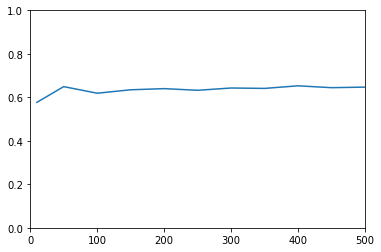

In [51]:
import matplotlib.pyplot as plt

test_sizes_list = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
mapk_results = []
for test_size in test_sizes_list:
    mapk_results.append(calc_mean_average_precision_k(test_character_list[:test_size], model))
    

plt.plot(test_sizes_list, mapk_results)
plt.axis([0, 500, 0, 1])
plt.show()

In [68]:
# final 4
model = Doc2Vec(alpha=0.25, min_alpha=0.025) 
model.build_vocab(train_corpus)
# %time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
for epoch in range(10):
    model.train(train_corpus, total_examples=model.corpus_count, epochs=epoch)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay
    
print calc_mean_average_precision_k(test_character_list[:200], model)

0.607888950913


In [38]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=8, min_count=19, iter=10) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 1min 33s, sys: 632 ms, total: 1min 34s
Wall time: 34.1 s


0.643467036911


In [39]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=8, min_count=19, iter=20) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 3min 10s, sys: 2.15 s, total: 3min 12s
Wall time: 1min 13s


0.641963598382


In [40]:
model = Doc2Vec(dm=1, dm_mean=1, size=300, window=8, min_count=19, iter=20) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 3min 54s, sys: 1.18 s, total: 3min 55s
Wall time: 1min 22s


0.649278035546


In [41]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=8, min_count=19, iter=100) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 15min 22s, sys: 6.62 s, total: 15min 28s
Wall time: 5min 35s


0.635627557614


In [43]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=20, min_count=19, iter=100) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 21min 46s, sys: 4.78 s, total: 21min 51s
Wall time: 7min 32s


0.6184851441


In [82]:
# final 4
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 13min 10s, sys: 5.4 s, total: 13min 15s
Wall time: 4min 51s


0.647298604327


In [83]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=20, iter=100) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 13min 5s, sys: 5.07 s, total: 13min 10s
Wall time: 4min 49s


0.647055708097


In [48]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=10, iter=100) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 13min 43s, sys: 6.3 s, total: 13min 50s
Wall time: 5min 4s


0.641714744505


In [49]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=100) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 13min 22s, sys: 8.45 s, total: 13min 31s
Wall time: 5min 4s


0.645888061985


In [51]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=100, alpha=0.25, min_alpha=0.01) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 10min 25s, sys: 6.76 s, total: 10min 32s
Wall time: 4min 10s


0.64739936922


In [71]:
# final 4
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=150) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 20min 2s, sys: 15 s, total: 20min 17s
Wall time: 7min 44s


0.619167139798


In [27]:
print model

Doc2Vec(dm/m,d200,n5,w4,mc15,s0.001,t3)


In [72]:
# final 4
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=200) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 26min 26s, sys: 15.7 s, total: 26min 41s
Wall time: 9min 59s


0.619998446705


In [56]:
model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=300) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(test_character_list[:200], model)

CPU times: user 39min 9s, sys: 22.4 s, total: 39min 31s
Wall time: 14min 46s


0.644189477281


In [89]:
# try to run against entire character test
character_list = []
for id in range(len(test_corpus)):
    character_list.append(id)

model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) 
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
print calc_mean_average_precision_k(character_list, model)

CPU times: user 13min 8s, sys: 5.06 s, total: 13min 13s
Wall time: 4min 49s


0.64917898177


In [91]:
# save model to be loaded later if needed
model.save('/tmp/movie_model.doc2vec')

## Test Results
Round 1
Doc2Vec(size=50, iter=20, min_count=2) : 0.64590552578393612<br/>
Doc2Vec(alpha=0.025, min_alpha=0.025)/decrease learning rate : 0.652129159832<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=8, min_count=19, iter=10) : 0.643467036911<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=8, min_count=19, iter=20) : 0.641963598382<br/>
Doc2Vec(dm=1, dm_mean=1, size=300, window=8, min_count=19, iter=20) : 0.649278035546<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=8, min_count=19, iter=100) : 0.635627557614<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) : 0.664204807617<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=20, iter=100) : 0.639810561736<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=10, iter=100) : 0.641714744505<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=100) : 0.645888DD061985<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=100, alpha=0.25, min_alpha=0.01) : 0.64739936922<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=150) : 0.6501950632<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=200) : 0.653454281673<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=300) : 0.644189477281<br/>
<br/>
Round 2 - new random test data<br/>
Doc2Vec(alpha=0.025, min_alpha=0.025)/decrease learning rate : 0.616014300118<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) : 0.644970657008<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=150) : 0.634117843088<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=200) : 0.638209043472<br/>
<br/>
Round 3 - new random test data<br/>
Doc2Vec(alpha=0.025, min_alpha=0.025)/decrease learning rate : 0.607888950913<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) : 0.614642972259<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=150) : 0.619167139798<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=200) : 0.619998446705<br/>
<br/>
Average<br/>
Doc2Vec(alpha=0.025, min_alpha=0.025)/decrease learning rate : (0.652129159832 + 0.616014300118 + 0.607888950913)/3 = 0.625344137<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) : (0.664204807617 + 0.644970657008 + 0.614642972259)/3 = 0.641272812<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=150) : (0.6501950632 + 0.634117843088 + 0.619167139798)/3 = 0.634493349<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=15, iter=200) : (0.653454281673+ 0.638209043472 + 0.619998446705)/3 = 0.637220591<br/>
<br/>
Round 4 - new random test data min_count 19 vs min_count 20<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) : 0.654732378791<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=20, iter=100) : 0.649219429736<br/>
<br/>
Round 5 - same random test data min_count 19 vs min_count 20<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) : 0.647298604327 <br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=20, iter=100) : 0.647055708097 <br/>
<br/>
MAP run with full test corpus<br/>
Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100) : 0.64917898177

## Sensitivity analysis
Test Doc2Vec model with random lines removed from the training_corpus. The model will be assessed the same way the original training_corpus was assessed.  

In [73]:
# altlines = open('cornell-movie-dialogs-corpus/movie_lines_mod.txt','r').read().split('\n')
from random import randint
from gensim import utils

altMovieLines = {}
altTotalLines = 0
for line in lines:
    if randint(0, 9) != 7:
        altTotalLines = altTotalLines+1
        _line = line.split(' +++$+++ ')
        if len(_line) == 5:
            if _line[2] in altMovieLines: 
                altMovieLines[_line[2]] = altMovieLines.get(_line[2]) + utils.simple_preprocess(_line[4])
            else:
                altMovieLines[_line[2]] = utils.simple_preprocess(_line[4])

In [74]:
print "Correct # of movies" if len(altMovieLines) == 617 else "something went wrong with movieLines dict"
print "# of lines were decreased" if altTotalLines < 304713 else "something went wrong with id2line dict"
print altTotalLines

Correct # of movies
# of lines were decreased
274412


In [75]:
alt_train_corpus = create_corpus(altMovieLines)
alt_model = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100)
alt_model.build_vocab(alt_train_corpus)
%time alt_model.train(alt_train_corpus, total_examples=alt_model.corpus_count, epochs=alt_model.iter)
print calc_mean_average_precision_k(test_character_list[:200], alt_model)

CPU times: user 20min 26s, sys: 7.13 s, total: 20min 33s
Wall time: 8min


0.663162180496


In [24]:
alt_model.save('/tmp/alt_model.doc2vec')

In [40]:
from gensim.models import Doc2Vec

alt_model = Doc2Vec.load('/tmp/alt_model.doc2vec')

Test Doc2Vec model with test_corpus (individual character converations) which consist of 9035 different documents.  The model will be assessed the same way the training_corpus was assessed.This is essentually recommending users to other users.  

In [28]:
# alt MAP functions to use test_corpus to train.  
def calc_average_precision2(recommendations, movie_id):
    metadata = get_character_metadata(movie_id)
    genres_str = get_movie_genres(metadata[2][1:])
    # print genres_str
    
    genres_str = genres_str.strip("[]").replace("'","").replace(" ", "")
    genre_list = genres_str.split(",")  
    predicted_list = []
    for item in recommendations:
        # print get_movie_genres(item[0])
        is_relevant = False
        for gen in genre_list:
            if gen in get_movie_genres(get_character_metadata(item[0])[2][1:]):
                if is_relevant is False:
                    # print "+"
                    is_relevant = True
        if is_relevant:
            predicted_list.append(1)
        else:
            predicted_list.append(0)
            
    # print predicted_list
    
    predicted_list = np.asarray(predicted_list) != 0
    out = [precision_at_k(predicted_list, k + 1) for k in range(predicted_list.size) if predicted_list[k]]
    if not out:
        return 0.
    return np.mean(out)


def calc_mean_average_precision_k2(test_list, test_model):
    av_list = []
    for char in test_list:
        d2v_result = get_doc2vec_similarity(char, test_model)
        av_list.append(calc_average_precision2(d2v_result, char))
    
    return np.mean(av_list)

In [31]:
model2 = Doc2Vec(dm=1, dm_mean=1, size=200, window=4, min_count=19, iter=100)
model2.build_vocab(test_corpus)
%time model2.train(test_corpus, total_examples=model2.corpus_count, epochs=model2.iter)
print calc_mean_average_precision_k2(test_character_list[:200], model2)

CPU times: user 43min 9s, sys: 28.6 s, total: 43min 37s
Wall time: 17min 36s


0.608206265221


In [28]:
model2.save('/tmp/character_model.doc2vec')

In [47]:
from gensim.models import Doc2Vec

model2 = Doc2Vec.load('/tmp/character_model.doc2vec')

Simple test of the first movie in the training corpus to ensure that the movie was returned as the most similar document by the model.  The similarity score is also displayed. A random document from the training coupus is aslo selected along and compared with the similarity score of the second most similar document.  

In [22]:
print('Movie title : {}\nMovie id : {}\n'.format(get_movie_title(train_corpus[doc_id].tags[0]), train_corpus[doc_id].tags[0]))
print(u'MODEL %s:\n' % model)

print get_movie_title(train_corpus[get_corpus_index(train_corpus, sims[0][0])].tags[0])
print sims[0], '\n\n----------------------\n'

# Pick a random document from the train corpus and infer a vector from the model
rand_train_id = random.randint(0, len(train_corpus))

# Inspect the score of the second ranked movie. 
# The score for the second ranked movie should be much lower then for the top document.
print('Train Document ({}): «{}»\n'.format(rand_train_id, get_movie_title(rand_train_id)))
top_id = first_ranks[get_corpus_index(train_corpus, rand_train_id)]
print('Top Document {}: «{}»\n'.format(top_id, get_movie_title(top_id[0])))
sim_id = second_ranks[get_corpus_index(train_corpus, rand_train_id)]
print('Similar Document {}: «{}»\n'.format(sim_id, get_movie_title(sim_id[0])))

Movie title : star wars
Movie id : 529

MODEL Doc2Vec(dm/m,d200,n5,w4,mc19,s0.001,t3):

star wars
(529, 0.9724684953689575) 

----------------------

Train Document (462): «notting hill»

Top Document (462, 0.9851363897323608): «notting hill»

Similar Document (263, 0.3918589651584625): «bean»



In [25]:
# Two characters from the same movie 
display_character_similarity(1220, False)
print("AP@20 for character 1220 : {}".format(calc_average_precision(get_doc2vec_similarity(1220, model), 1220)))
display_character_similarity(1223, False)
print("AP@20 for character 1223 : {}".format(calc_average_precision(get_doc2vec_similarity(1223, model), 1223)))

Character : EDDIE
 ID : m80
 Movie : halloween h20: 20 years later
[(379, 0.6426482200622559), (499, 0.34675082564353943), (342, 0.34512200951576233), (188, 0.3361318111419678), (447, 0.332575261592865), (376, 0.33209237456321716), (212, 0.32587167620658875), (20, 0.3134957551956177), (359, 0.31340932846069336), (59, 0.31223708391189575)]

Top 5
 halloween
 sleepless in seattle
 the fabulous baker boys
 someone to watch over me
 arcade

('halloween h20: 20 years later', 66, 0.23796817660331726) 

AP@20 for character 1220 : 0.843616907688
Character : KERI
 ID : m80
 Movie : halloween h20: 20 years later
[(439, 0.5598339438438416), (276, 0.37651336193084717), (372, 0.3285962641239166), (425, 0.3180466890335083), (467, 0.31794071197509766), (281, 0.31404656171798706), (38, 0.30948635935783386), (154, 0.3086808919906616), (324, 0.3023444712162018), (231, 0.30112865567207336)]

Top 5
 midnight express
 blow
 goodfellas
 lost in translation
 out of sight

('halloween h20: 20 years later', 31

AP@20 for character 1223 : 0.866611021569


In [26]:
# compare results from three characters that have conversations in a movie and a random character
# Star wars : Hans, Luke and Vader
# u7821 +++$+++ HAN +++$+++ m529
display_character_similarity(7821, False)

# u7824 +++$+++ LUKE +++$+++ m529
display_character_similarity(7824, False)

# u7827 +++$+++ VADER
display_character_similarity(7827, True)

# random character from test corpus
display_character_similarity(random.randint(0, len(test_corpus)), False)

Character : HAN
 ID : m529
 Movie : star wars
[(92, 0.6449993848800659), (430, 0.3893139362335205), (65, 0.37343278527259827), (216, 0.3703673481941223), (158, 0.35381242632865906), (349, 0.3520643711090088), (222, 0.35035082697868347), (359, 0.3476943075656891), (488, 0.32488399744033813), (170, 0.3181003928184509)]

Top 5
 house of 1000 corpses
 manhunt
 from dusk till dawn
 thelma & louise
 pet sematary

('star wars', 487, 0.07965101301670074) 

Character : LUKE
 ID : m529
 Movie : star wars
[(92, 0.8937079310417175), (217, 0.3398858308792114), (314, 0.33799755573272705), (237, 0.3355068862438202), (537, 0.33118876814842224), (61, 0.3258844316005707), (349, 0.323481947183609), (72, 0.32014745473861694), (41, 0.31066903471946716), (430, 0.3015619218349457)]

Top 5
 house of 1000 corpses
 there's something about mary
 the curse
 alien vs. predator
 suburbia

('star wars', 507, 0.0231881532818079) 

Character : VADER
 ID : m529
 Movie : star wars
Test Document (7827): «enough already k

In [27]:
# two characters that only have conversations with each other so they have identical words in their document
display_character_similarity(5519, True)
display_character_similarity(5508, True)

Character : PETER
 ID : m367
 Movie : get carter
Test Document (5519): «gerald phoned us in the middle of the night said he heard you ve been making nuisance of yourself we ve got to take you back to london he said it be doing him big favour we know why you re all steamed up and so do gerald and sid but they have to be diplomatic put it away jack you know you won use it the gun he means gerald wants to see him first shut up»

[(465, 0.50835782289505), (345, 0.3186812698841095), (58, 0.31676313281059265), (203, 0.3082112967967987), (270, 0.30003443360328674), (444, 0.2980826199054718), (388, 0.2907238006591797), (228, 0.2814142107963562), (24, 0.2809237539768219), (530, 0.2664611041545868)]

Top 5
 on the waterfront
 the fantastic four
 fantastic four
 the godfather
 the black dahlia

('get carter', 239, 0.14768920838832855) 

Character : CON
 ID : m367
 Movie : get carter
Test Document (5508): «gerald phoned us in the middle of the night said he heard you ve been making nuisance of you

In [28]:
# two characters that only have conversations with each other so they have identical words in their document
display_character_similarity(259, True)
display_character_similarity(265, True)

Character : PAPAGENO
 ID : m16
 Movie : amadeus
Test Document (259): «here am my angel what who the devil are you ve taken pity on you my angel heard your wish oh well thank you how wonderful some people get all the luck now you ve got to promise me faithfully you ll remain true to me forever then you ll see how tenderly your little birdie will love you can wait well promise then what do you mean now of course now right away before get any older well don know mean you re delicious delightful delectable little bird but don you think you might be just little tough oh tender enough for you my boy tender enough for you»

[(369, 0.48146891593933105), (203, 0.3504234254360199), (494, 0.3287377655506134), (424, 0.32663020491600037), (272, 0.3177914023399353), (387, 0.31425905227661133), (613, 0.3100992441177368), (436, 0.3068705201148987), (309, 0.2976357638835907), (581, 0.2970328629016876)]

Top 5
 the godfather: part ii
 the godfather
 ronin
 lord of illusions
 blade

('amadeus', 83, 0.244

The Doc2Vec algorithm starts by giving distinct document-IDs an initial random vector; also most training modes include some randomized steps. So even identical runs-of-words won't necessarily result in identically-trained vectors. Rather, they'll tend to become closer over training – perhaps arbitrarily close with enough passes, but never identical. - https://groups.google.com/forum/#!topic/gensim/LLmPa4LECXs